# Average epidemic trajectory on an activity-driven-network

## Summary

In this tutorial, we show how to simulate and analyze a SIS epidemic on an activity driven network.

The network model is based on the paper *Cai, C. R., Nie, Y. Y., & Holme, P. (2024). Epidemic criticality in temporal networks. Physical Review Research, 6(2), L022017.*



The network consists of two types of nodes: *active* or *inactive*. Active nodes become inactive at a rate `recovery_rate` and inactive nodes becomes active at their own rate, determined by the array `activity_rates`. For this example, we assume that nodes have an activity rate that is uniformly distributed on $[0.01,5]$ and become inactive at unit rate. 

## Network Analysis

In [1]:
import nextnet as nn 
import numpy as np 
import matplotlib.pyplot as plt

# random generator
seed=1 
rng = nn.rng(seed)

In [47]:
# Network parameters

n = 10**3  # number of nodes in the network
low = 0.01
high = 5
activity_rates = np.random.uniform(low, high, n)

g = nn.activity_driven_network(
    activity_rates,
    eta= 1, # strength of activity
    m = 5, #number of links created
    recovery_rate = 1,
    rng = rng)

### Single trajectory

We compute a SIS trajectory with an infectiousness that is periodic and recovery times that are gamma distributed with mean $7$ and variance $1$

In [ ]:
tau = np.arange(0.01,20,0.01)
infectiousness = np.sin(tau*np.pi/10)**2
psi = nn.transmission_time_infectiousness(tau,infectiousness)
rho = nn.transmission_time_gamma(7,1)

sim = nn.simulation_temporal(g,psi,rho,SIR=False)
sim.add_infections([(0,0)])

opt = {"time": 40, "network_events":False,"epidemic_events":True} #dictionary of options

results = sim.run(rng,opt) 

plt.plot(results["time"],results["infected"])
plt.xlabel("time $t$")
plt.ylabel("number of infected")
plt.title("SIS trajectory on Activity-Driven Network")
plt.show()

RuntimeError: node is already infected

### Average trajectory

The above trajectory is a stochastic trajectory and does not seem to self-average. We can compute the average trajectory of the SIS epidemic. To run a new epidemic, we need to create a new instance of the activity-driven network. If one wants to create the same network as before, the same seed needs to be specified

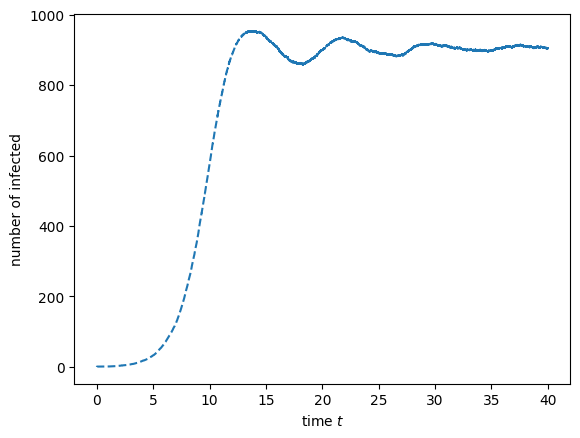

In [ ]:
nb_sim=15
infected = []
times = []
for repeat in range(nb_sim):

	g = nn.activity_driven_network(
		activity_rates,
		eta= 1, # strength of activity
		m = 5, #number of links created
		recovery_rate = 1,
		rng = rng)

	sim = nn.simulation_temporal(g,psi,rho,SIR=False)
	sim.add_infections([(0,0)])

	opt = {"time": 40, "network_events":False,"epidemic_events":True} #dictionary of options

	results = sim.run(rng,opt) 
	infected += [1/nb_sim if event[-1]==0 else -1/nb_sim  for event in results["data"]]
	times +=results["time"]

pairs = sorted(zip(times, infected), key=lambda x: x[0])
times_sorted, infected_sorted = zip(*pairs)

plt.plot(times_sorted,np.cumsum(infected_sorted),'--')
plt.xlabel("time $t$")
plt.ylabel("number of infected")
plt.title("Average trajectory on Activity-Driven Network")
plt.show()

A few remarks:
- Memory usage: This exact method computes the average trajectory by storing all individual trajectories and sorting them afterward. However, it is memory-intensive; for larger networks or many simulations, consider implementing a streaming or online algorithm to reduce peak memory consumption.
- Steady-state initialization: We seeded the epidemic at time $t=0$, when the network dynamics had not yet reached steady state. To ensure equilibration, introduce the first infection at time $t = t_{\rm init}$ within the simulator. By the time this initial infection occurs, the network will have stabilized into a steady state.

